In [1]:
import gc
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
BASE = '../input/godaddy-microbusiness-density-forecasting/'

# error calculation function smape
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

# error vector calculation function
def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [2]:
# loading data
census = pd.read_csv(BASE + 'census_starter.csv')
train = pd.read_csv(BASE + 'train.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')
# loading additional data
reaveal_test = pd.read_csv(BASE + 'revealed_test.csv')
# attaching additional data
train = pd.concat([train, reaveal_test]).sort_values(by=['cfips','first_day_of_month']).reset_index()
test = pd.read_csv(BASE + 'test.csv')
drop_index = (test.first_day_of_month == '2022-11-01') | (test.first_day_of_month == '2022-12-01')
test = test.loc[~drop_index,:]
# loading geodata
coords = pd.read_csv("/kaggle/input/usa-counties-coordinates/cfips_location.csv")
print(train.shape, test.shape, sub.shape)
# data aggregation
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
raw = raw.merge(coords.drop("name", axis=1), on="cfips")
# creating new columns
raw['state_i1'] = raw['state'].astype('category')
raw['county_i1'] = raw['county'].astype('category')
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw['scale'] = (raw['first_day_of_month'] - raw['first_day_of_month'].min()).dt.days
raw['scale'] = raw['scale'].factorize()[0]
# use GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"


(128535, 8) (18810, 3) (25080, 2)


In [3]:
for o in tqdm(raw.cfips.unique()): 
    indices = (raw['cfips'] == o) 
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    for i in range(37, 2, -1):
        thr = 0.10 * np.mean(var[:i]) 
        difa = var[i] - var[i - 1] 
        if (difa >= thr) or (difa <= -thr):              
            if difa > 0:
                var[:i] += difa - 0.003 
            else:
                var[:i] += difa + 0.003  
    var[0] = var[1] * 0.99
    raw.loc[indices, 'microbusiness_density'] = var


  0%|          | 0/3135 [00:00<?, ?it/s]

<AxesSubplot:xlabel='dcount'>

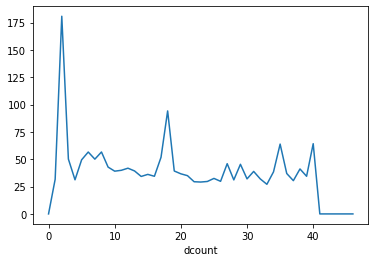

In [4]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

In [5]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target']/raw['microbusiness_density'] - 1


raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

<AxesSubplot:>

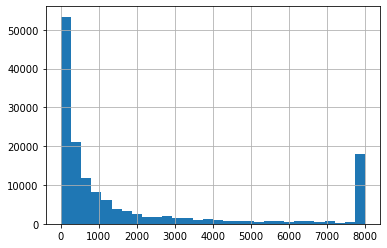

In [6]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

dt = raw.loc[raw.dcount==40].groupby('cfips')['microbusiness_density'].agg('last')
raw['lastactive'].clip(0, 8000).hist(bins=30)

# Feature Engineering
> Try tuning this part

In [7]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []   

    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6, 8, 10]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        feats.append(f'mbd_rollmea{window}_{lag}')
    
    census_columns = list(census.columns)
    census_columns.remove( "cfips")
    
    raw = raw.merge(census, on="cfips", how="left")
    feats += census_columns
    # loading additional data
    co_est = pd.read_csv("/kaggle/input/us-indicator/co-est2021-alldata.csv", encoding='latin-1')
    co_est["cfips"] = co_est.STATE*1000 + co_est.COUNTY
    co_columns = [
        'SUMLEV',
        'DIVISION',
        'ESTIMATESBASE2020',
        'POPESTIMATE2020',
        'POPESTIMATE2021',
        'NPOPCHG2020',
        'NPOPCHG2021',
        'BIRTHS2020',
        'BIRTHS2021',
        'DEATHS2020',
        'DEATHS2021',
        'NATURALCHG2020',
        'NATURALCHG2021',
        'INTERNATIONALMIG2020',
        'INTERNATIONALMIG2021',
        'DOMESTICMIG2020',
        'DOMESTICMIG2021',
        'NETMIG2020',
        'NETMIG2021',
        'RESIDUAL2020',
        'RESIDUAL2021',
        'GQESTIMATESBASE2020',
        'GQESTIMATES2020',
        'GQESTIMATES2021',
        'RBIRTH2021',
        'RDEATH2021',
        'RNATURALCHG2021',
        'RINTERNATIONALMIG2021',
        'RDOMESTICMIG2021',
        'RNETMIG2021'
    ]
    raw = raw.merge(co_est, on="cfips", how="left")
    feats +=  co_columns
    return raw, feats

In [8]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 9)
features = ['state_i'] # state number 
features += feats
features += ['lng','lat','scale'] # geodata coordinates and day number
print(features)
raw.loc[raw.dcount==40, features].head(10)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_lag_4', 'act_lag_4', 'mbd_lag_5', 'act_lag_5', 'mbd_lag_6', 'act_lag_6', 'mbd_lag_7', 'act_lag_7', 'mbd_lag_8', 'act_lag_8', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1', 'mbd_rollmea8_1', 'mbd_rollmea10_1', 'pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017', 'pct_college_2018', 'pct_college_2019', 'pct_college_2020', 'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018', 'pct_foreign_born_2019', 'pct_foreign_born_2020', 'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018', 'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021', 'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019', 'median_hh_inc_2020', 'median_hh_inc_2021', 'SUMLEV', 'DIVISION', 'ESTIMATESBASE2020', 'POPESTIMATE2020', 'POPESTIMATE2021', 'NPOPCHG2020', 'NPOPCHG2021', 'BIRTHS2020', 'BIRTHS2021', 'DEATHS2020', 'DEATHS2021

,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_lag_4,act_lag_4,mbd_lag_5,...,GQESTIMATES2021,RBIRTH2021,RDEATH2021,RNATURALCHG2021,RINTERNATIONALMIG2021,RDOMESTICMIG2021,RNETMIG2021,lng,lat,scale
40,0,0.008202,12.0,-0.006114,3.0,0.006152,12.0,0.005498,20.0,-0.004107,...,442,11.002611,11.545112,-0.542502,0.084766,4.017903,4.102668,-86.642900,32.535142,40
87,0,-0.000848,-12.0,-0.012221,-187.0,0.002170,-156.0,-0.017601,-412.0,-0.009601,...,2177,9.567474,12.137145,-2.569671,0.266704,28.702422,28.969126,-87.722745,30.727825,40
134,0,0.004049,1.0,0.012295,4.0,0.020921,9.0,0.008439,11.0,-0.016597,...,2789,10.928526,15.714742,-4.786216,0.039885,-3.908743,-3.868858,-85.391068,31.870090,40
181,0,0.008811,2.0,-0.008734,0.0,-0.021367,-5.0,0.017391,-1.0,-0.025424,...,2062,10.111857,12.617450,-2.505593,0.089485,13.825503,13.914989,-87.126814,32.998376,40
228,0,0.008589,7.0,0.002460,9.0,-0.010949,0.0,0.008589,7.0,0.002460,...,449,10.650006,13.883950,-3.233945,0.033863,2.370431,2.404294,-86.567006,33.980871,40
275,0,0.012500,1.0,0.025641,3.0,0.012987,4.0,0.013158,5.0,0.013333,...,1725,12.603616,12.506665,0.096951,0.096951,0.678656,0.775607,-85.715729,32.100459,40
322,0,0.005970,2.0,0.000000,2.0,0.009036,5.0,0.027864,14.0,0.031949,...,241,11.284242,15.555380,-4.271138,0.158190,-4.376598,-4.218408,-86.680409,31.752524,40
369,0,0.002808,7.0,-0.005981,-8.0,-0.003180,-16.0,0.007609,3.0,0.002006,...,3251,11.367649,14.743496,-3.375847,0.034447,0.602830,0.637277,-85.825747,33.771415,40
416,0,0.002571,1.0,0.018325,8.0,-0.040201,-8.0,-0.012407,-13.0,-0.017073,...,449,10.286193,14.793626,-4.507433,0.606770,-0.231150,0.375619,-85.391689,32.913666,40
463,0,0.008368,2.0,0.017021,6.0,-0.012605,3.0,0.000000,3.0,-0.008333,...,181,9.528766,18.937422,-9.408656,0.040037,10.849982,10.890019,-85.603871,34.175887,40


Latitude and Longitude feature engineering from samu2505.

In [9]:
# geodata processing
coordinates = raw[['lng', 'lat']].values

# Encoding tricks
emb_size = 20
precision = 1e6

latlon = np.expand_dims(coordinates, axis=-1)

m = np.exp(np.log(precision)/emb_size)
angle_freq = m ** np.arange(emb_size)
angle_freq = angle_freq.reshape(1,1, emb_size)
latlon = latlon * angle_freq
latlon[..., 0::2] = np.cos(latlon[..., 0::2])

In [10]:
def rot(df):
    for angle in [15, 30, 45]:
        df[f'rot_{angle}_x'] = (np.cos(np.radians(angle)) * df['lat']) + \
                                (np.sin(np.radians(angle)) * df['lng'])
        
        df[f'rot_{angle}_y'] = (np.cos(np.radians(angle)) * df['lat']) - \
                                (np.sin(np.radians(angle)) * df['lng'])
        
    return df

raw = rot(raw)

In [11]:
features += ['rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y']

In [12]:
def get_model():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer    

# we should decrease the num_iterations of catboost
    cat_model = cat.CatBoostRegressor(
        iterations=2000,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.2,
        subsample=0.70,
        max_bin=4096,
    )

    return cat_model


def base_models():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer    
    
    # LGBM model
    params = {
    'n_iter': 300,
    'boosting_type': 'dart',
    'verbosity': -1,
    'objective': 'l1',
    'random_state': 42,
    'colsample_bytree': 0.8841279649367693,
    'colsample_bynode': 0.10142964450634374,
    'max_depth': 8,
    'learning_rate': 0.003647749926797374,
    'lambda_l2': 0.5,
    'num_leaves': 61,
    "seed": 42,
    'min_data_in_leaf': 213}

    lgb_model = lgb.LGBMRegressor(**params)
    
    xgb_model = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    tree_method="hist",
    n_estimators=795,
    learning_rate=0.0075,
    max_leaves = 17,
    subsample=0.50,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2)

    # we should decrease the num_iterations of catboost
    cat_model = cat.CatBoostRegressor(
        iterations=2500,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.2,
        subsample=0.70,
        max_bin=4096,
    )
    
    models = {}
    models['xgb'] = xgb_model
    models['lgbm'] = lgb_model
    models['cat'] = cat_model

    return models

In [13]:
ACT_THR = 150
MONTH_1 = 39
MONTH_last = 40

In [14]:
raw[raw.istest == 0].shape

(128535, 107)

In [15]:
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
raw['microbusiness_density'].fillna(0, inplace = True)

for TS in range(MONTH_1, MONTH_last): 
    print(f'TS: {TS}')
  
    models = base_models()
    model0 = models['xgb']
    model1 = models['lgbm']
    model2 = models['cat']
            
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) 
    valid_indices = (raw.istest==0) & (raw.dcount == TS) 
    
    # Train each of the models on the current TS
    model0.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.002, 0.006))
    
    model1.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.002, 0.006))
    
    model2.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.002, 0.006))
    

    tr_pred0 = model0.predict(raw.loc[train_indices, features])
    tr_pred1 = model1.predict(raw.loc[train_indices, features])
    tr_pred2 = model2.predict(raw.loc[train_indices, features])
    train_preds = np.column_stack((tr_pred0, tr_pred1, tr_pred2))
    
    meta_model = get_model() 
    meta_model.fit(train_preds, raw.loc[train_indices, 'target'].clip(-0.002, 0.006))
    
    val_preds0 = model0.predict(raw.loc[valid_indices, features])
    val_preds1 = model1.predict(raw.loc[valid_indices, features])
    val_preds2 = model2.predict(raw.loc[valid_indices, features])
    valid_preds = np.column_stack((val_preds0, val_preds1, val_preds2))
    
    ypred = meta_model.predict(valid_preds)
    # get value 'microbusiness_density' from target
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), 
                 ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)  
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
        
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()

ind = (raw.dcount > MONTH_1)&(raw.dcount <= MONTH_last)

print('SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred']))
print('Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last']))

TS: 39


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
Last Value SMAPE: 1.889206717018118
SMAPE: 1.8626317878552674

SMAPE: 1.8626317878552674
Last Value SMAPE: 1.889206717018118


In [16]:
raw[raw['microbusiness_density'].isnull()]

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,...,RNETMIG2021,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y,ypred_last,ypred,k


In [17]:
TS = 40
print(TS)

model0 = get_model()

train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) 
valid_indices = (raw.dcount == TS)

model0.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.002, 0.006))
    
model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.002, 0.006))

model2.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.002, 0.006))


tr_pred0 = model0.predict(raw.loc[train_indices, features])
tr_pred1 = model1.predict(raw.loc[train_indices, features])
tr_pred2 = model2.predict(raw.loc[train_indices, features])
train_preds = np.column_stack((tr_pred0, tr_pred1, tr_pred2))

meta_model = get_model() 
meta_model.fit(train_preds, raw.loc[train_indices, 'target'].clip(-0.002, 0.006))

val_preds0 = model0.predict(raw.loc[valid_indices, features])
val_preds1 = model1.predict(raw.loc[valid_indices, features])
val_preds2 = model2.predict(raw.loc[valid_indices, features])
valid_preds = np.column_stack((val_preds0, val_preds1, val_preds2))

ypred = meta_model.predict(valid_preds)

# ypred = model0.predict(raw.loc[valid_indices, features])
raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

# Validate
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

40


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300


In [18]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)

In [19]:
df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)

df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']

raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [20]:
mask = (raw.lastactive > 150) & (raw.dcount==(TS+1))
k = 0.1
raw.loc[mask, 'ypred'] = k * 1.01 * raw.loc[mask, 'ypred_last'] + (1-k) * raw.loc[mask, 'ypred'] 

In [21]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

In [22]:
COLS = ['GEO_ID','NAME','S0101_C01_026E']
df2020 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2020.S0101-Data.csv', usecols=COLS, dtype = 'object')
df2021 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2021.S0101-Data.csv',usecols=COLS, dtype = 'object')

df2020 = df2020.iloc[1:]
df2020 = df2020.astype({'S0101_C01_026E':'int'})

df2021 = df2021.iloc[1:]
df2021 = df2021.astype({'S0101_C01_026E':'int'})

df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]))
adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]))
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

df2020['mnoshitel'] = df2020['S0101_C01_026E'] / df2021['S0101_C01_026E']

df2020 = df2020[['cfips','mnoshitel']]
df2020.set_index('cfips', inplace=True)

In [23]:
raw = raw.join(df2020, on='cfips')
maska = (raw["first_day_of_month"]=='2023-01-01')
raw.loc[maska, 'microbusiness_density'] = raw.loc[maska, 'ypred'] * raw.loc[maska, 'mnoshitel']
raw.drop(columns = 'mnoshitel' , inplace = True)

In [24]:
test = raw[raw.first_day_of_month >= '2022-11-01'].copy()
test = test[['row_id', 'cfips', 'microbusiness_density']]
test = test[['row_id', 'microbusiness_density']]
test.to_csv('submission.csv', index=False)

In [25]:
sub = pd.read_csv("/kaggle/input/godaddy-lb-13803/submission.csv")
for i, row in sub.iterrows():
    test.iat[i,1] = (
        0.65*test.iat[i,1] +
        0.35*row["microbusiness_density"]
    )
test.to_csv('submission1.csv', index=False)
test.head()

,row_id,microbusiness_density
39,1001_2022-11-01,3.405280
40,1001_2022-12-01,3.423634
41,1001_2023-01-01,3.337904
42,1001_2023-02-01,1.167540
43,1001_2023-03-01,1.167540


In [26]:
import pandas as pd
import numpy as np

# submission from
submission = pd.read_csv('submission1.csv')
submission['cfips'] = submission['row_id'].map(lambda x: int(x.split('_')[0]))

# get adult_population
column_names = ['GEO_ID','NAME','S0101_C01_026E']
df2021 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2021.S0101-Data.csv', usecols=column_names)
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]))
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

submission['adult2021'] = submission['cfips'].map(adult2021)

# rounding to the nearest integer
submission['microbusiness_density'] = (
    np.round(submission['microbusiness_density'] * submission['adult2021'] / 100) / submission['adult2021'] * 100
)

submission[['row_id', 'microbusiness_density']].to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
